In [2]:
# Import libraries
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('../data/merged_dataset_final.csv')

In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load cleaned dataset from Notebook 2
df = pd.read_csv('../data/merged_dataset_cleaned.csv')


In [5]:
# Features to scale for clustering
cluster_features = ['StudyHours','Attendance','Resources','Extracurricular',
                    'Motivation','Internet','OnlineCourses','Discussions',
                    'AssignmentCompletion','EduTech','StressLevel']

scaler_mm = MinMaxScaler()
df_scaled_mm = df.copy()
df_scaled_mm[cluster_features] = scaler_mm.fit_transform(df[cluster_features])


In [6]:
X = df_scaled_mm[cluster_features]  # Min-Max scaled features for clustering


In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Elbow Method
inertia = []
sil_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X, kmeans.labels_))

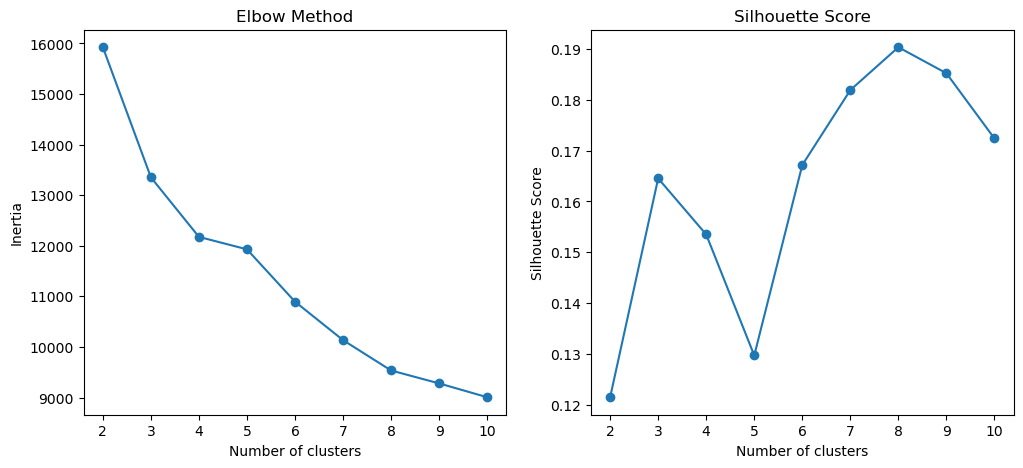

In [8]:
# Plot Elbow
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(2,11), inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")

# Plot Silhouette Score
plt.subplot(1,2,2)
plt.plot(range(2,11), sil_scores, marker='o')
plt.title("Silhouette Score")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [9]:
# Suppose elbow + silhouette suggest 4 clusters
k_opt = 4
kmeans = KMeans(n_clusters=k_opt, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Check cluster counts
print(df['Cluster'].value_counts())

Cluster
3    3651
0    3470
1    3101
2    2247
Name: count, dtype: int64


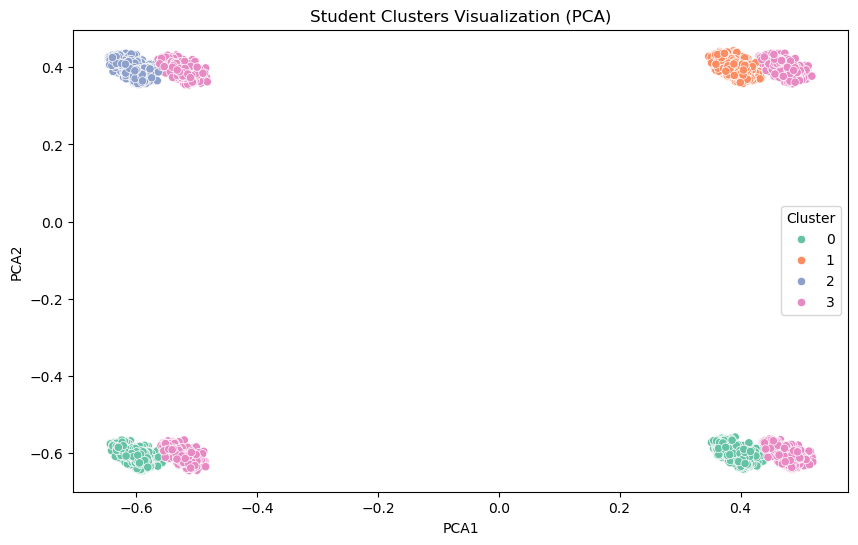

In [10]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce to 2D for plotting
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)

df['PCA1'] = pca_components[:,0]
df['PCA2'] = pca_components[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='Set2', data=df)
plt.title("Student Clusters Visualization (PCA)")
plt.show()


In [11]:
# Mean values per cluster
cluster_summary = df.groupby('Cluster')[cluster_features + ['FinalGrade', 'ExamScore']].mean()
print(cluster_summary)

         StudyHours  Attendance  Resources  Extracurricular  Motivation  \
Cluster                                                                   
0         19.978098   80.265130   1.102305         0.577233    0.923055   
1         20.204128   80.347307   1.086746         1.000000    0.920993   
2         20.097018   80.205162   1.109924         0.000000    0.893636   
3         19.905231   80.143796   1.107642         0.593536    0.889345   

         Internet  OnlineCourses  Discussions  AssignmentCompletion  EduTech  \
Cluster                                                                        
0        0.920461       9.794524     0.000000             74.503458      1.0   
1        0.906482       9.814253     1.000000             74.498549      1.0   
2        0.929684       9.946595     1.000000             74.748999      1.0   
3        0.915092       9.950151     0.605588             74.397151      0.0   

         StressLevel  FinalGrade  ExamScore  
Cluster               

In [12]:
# Most frequent LearningStyle per cluster
cluster_styles = df.groupby('Cluster')['LearningStyle'].agg(lambda x: x.value_counts().idxmax())
print("Cluster → Dominant Learning Style:\n", cluster_styles)

Cluster → Dominant Learning Style:
 Cluster
0    2
1    1
2    1
3    0
Name: LearningStyle, dtype: int64


In [13]:
from scipy.stats import f_oneway

# ANOVA for FinalGrade
groups_final = [df[df['Cluster']==i]['FinalGrade'] for i in df['Cluster'].unique()]
anova_final = f_oneway(*groups_final)
print("ANOVA FinalGrade: F =", anova_final.statistic, ", p =", anova_final.pvalue)

# ANOVA for ExamScore
groups_exam = [df[df['Cluster']==i]['ExamScore'] for i in df['Cluster'].unique()]
anova_exam = f_oneway(*groups_exam)
print("ANOVA ExamScore: F =", anova_exam.statistic, ", p =", anova_exam.pvalue)


ANOVA FinalGrade: F = 5.065789049383437 , p = 0.001662274799028106
ANOVA ExamScore: F = 3.210708896328779 , p = 0.021999961677757585


In [14]:
import statsmodels.api as sm

# Features for regression
X = df[['StudyHours','Attendance','Extracurricular','Motivation','OnlineCourses','AssignmentCompletion','Discussions']]
y = df['FinalGrade']

# Add constant for intercept
X = sm.add_constant(X)

# Fit OLS regression
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             FinalGrade   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.686
Date:                Tue, 20 Jan 2026   Prob (F-statistic):           1.41e-06
Time:                        09:25:12   Log-Likelihood:                -19108.
No. Observations:               12469   AIC:                         3.823e+04
Df Residuals:                   12461   BIC:                         3.829e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.5324 

In [15]:
df.to_csv('../data/merged_dataset_final.csv', index=False)
